In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

torch.manual_seed(42)
np.random.seed(42)

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = torch.from_numpy(train_X).float().reshape(-1, 28 * 28) / 255
train_y = torch.from_numpy(train_y).long()

test_X = torch.from_numpy(test_X).float().reshape(-1, 28 * 28) / 255
test_y = torch.from_numpy(test_y).long()

In [3]:
class MLP(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super().__init__()
        self.act = act
        self.l1 = nn.Linear(28 * 28, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 10)
        # we ignore the solfmax layer here, because we will be predicting the logits
        
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        x = self.act(x)
        x = self.l4(x)
        return x
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [4]:
def train(model, lr=0.01, epochs=100, verbose=False, optimizer='adam', reg=0):
	loss = nn.CrossEntropyLoss()
	optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg) if optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=lr)
	
	losses = []
	for i in range(epochs):
		optim.zero_grad()
		pred = model(train_X)
		l = loss(pred, train_y)
		l.backward()
		optim.step()
		losses.append(l.item())
  
		if verbose and i % (epochs//10) == 0:
			print(f"Epoch {i} Loss: {l.item()}")
  
	return losses

In [ ]:
model = MLP(act=nn.Sigmoid())
losses = train(model, lr=0.001, epochs=5000, verbose=True, reg=1e-5)

Epoch 0 Loss: 2.32873272895813
Epoch 500 Loss: 0.097419373691082
Epoch 1000 Loss: 0.012913870625197887
Epoch 1500 Loss: 0.005220979452133179
Epoch 2000 Loss: 0.0035765517968684435
Epoch 2500 Loss: 0.002834911923855543
Epoch 3000 Loss: 0.002161999698728323
Epoch 3500 Loss: 0.001841495162807405
Epoch 4000 Loss: 0.0016334813553839922
Epoch 4500 Loss: 0.001490329741500318


In [6]:
model = torch.load('./models/mlp_large.pth', map_location='cpu')

C:\Users\DELL\AppData\Local\Temp\ipykernel_7576\590524421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./models/mlp_large.pth', map_location='cpu'

In [7]:
def print_metrics(model):
	pred = model.predict(test_X)
	acc = (pred == test_y).float().mean()
	print(f"Accuracy: {acc.item()}")
  
	cm = confusion_matrix(test_y, pred)

	f1 = f1_score(test_y, pred, average=None)
	accuracies = []
	recalls = []
 
	for i in range(10):
		accuracies.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
		recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))
	df = pd.DataFrame(np.array([f1, accuracies, recalls]).T, index=range(10), columns=["F1 Score", "Accuracy", "Recall"])
	df.index.name = "Class"
	display(df.T)
 
	plt.figure(figsize=(6, 6))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
	plt.title("Confusion Matrix")
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()
 
def plot_losses(losses):
	plt.plot(losses)
	plt.title("Losses")
	plt.xlabel("Epoch")
	plt.ylabel("Loss") 

Accuracy: 0.9732999801635742


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.984741,0.988576,0.974284,0.967838,0.977053,0.964286,0.977011,0.968370,0.965092,0.963111
Accuracy,0.981744,0.985977,0.975705,0.967359,0.978550,0.960000,0.978033,0.968841,0.965092,0.968907
Recall,0.987755,0.991189,0.972868,0.968317,0.975560,0.968610,0.975992,0.967899,0.965092,0.957384


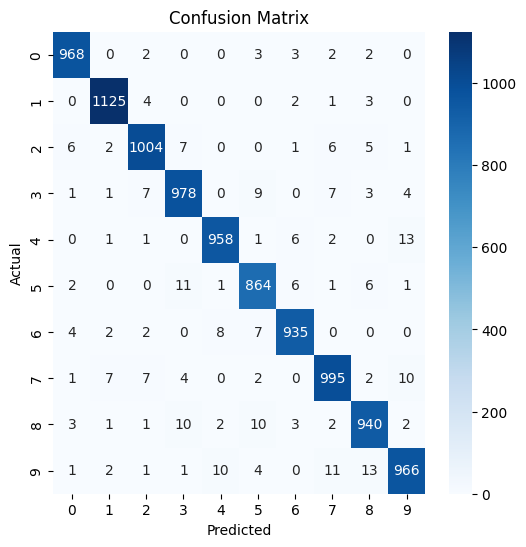

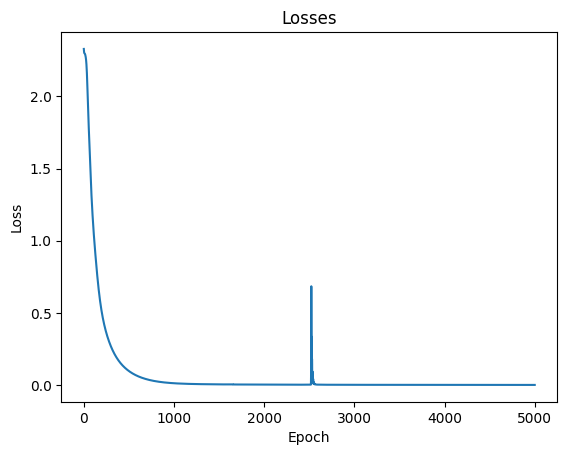

In [ ]:
print_metrics(model)
plot_losses(losses)

torch.save(model, 'models/mlp_large.pth')

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(28 * 28, 10)
        # Note that the activation is automatically applied in the loss function.
        
    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [ ]:
model = LogisticRegression()
losses = train(model, lr=3e-4, epochs=5000, verbose=True)

Epoch 0 Loss: 2.338815689086914
Epoch 500 Loss: 0.5376607179641724
Epoch 1000 Loss: 0.39382871985435486
Epoch 1500 Loss: 0.33996298909187317
Epoch 2000 Loss: 0.3106463849544525
Epoch 2500 Loss: 0.2916393280029297
Epoch 3000 Loss: 0.2780061960220337
Epoch 3500 Loss: 0.2675793766975403
Epoch 4000 Loss: 0.2592509686946869
Epoch 4500 Loss: 0.2523917555809021


In [11]:
model = torch.load('./models/lr.pth', map_location='cpu')

C:\Users\DELL\AppData\Local\Temp\ipykernel_7576\1119120393.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./models/lr.pth', map_location='cpu')


Accuracy: 0.9267999529838562


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.966700,0.973730,0.915020,0.909990,0.932995,0.891938,0.944703,0.924427,0.885845,0.912525
Accuracy,0.956088,0.967798,0.933468,0.909091,0.930162,0.910152,0.935517,0.926686,0.875627,0.915254
Recall,0.977551,0.979736,0.897287,0.910891,0.935845,0.874439,0.954071,0.922179,0.896304,0.909812


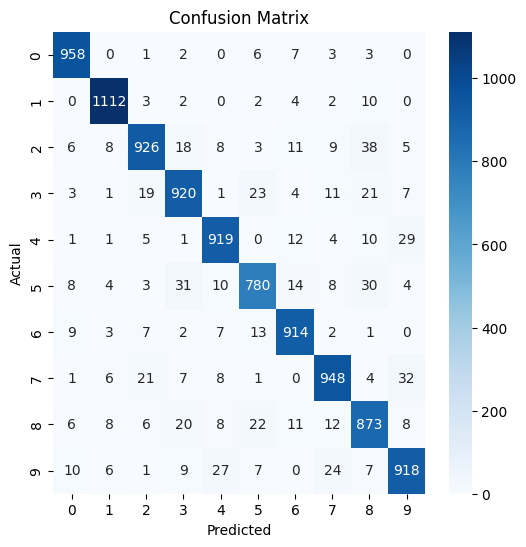

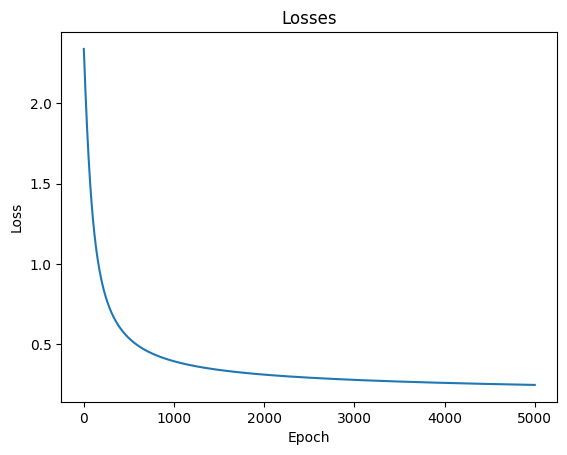

In [ ]:
print_metrics(model)
plot_losses(losses)
torch.save(model, 'lr.pth')

Accuracy: 0.9697999954223633


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.982314,0.988111,0.965717,0.962376,0.973966,0.965672,0.977592,0.965787,0.959877,0.954320
Accuracy,0.972973,0.987676,0.962464,0.962376,0.976459,0.969492,0.976067,0.970530,0.961856,0.956219
Recall,0.991837,0.988546,0.968992,0.962376,0.971487,0.961883,0.979123,0.961089,0.957906,0.952428


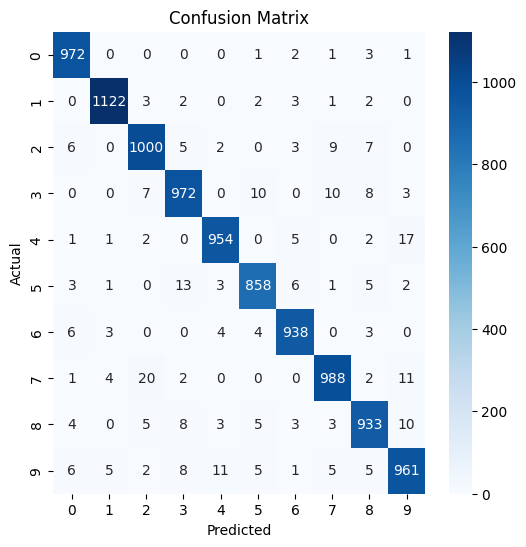

In [47]:
# Train a random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini')
rf.fit(train_X, train_y)

print_metrics(rf)

In [48]:
class MLP(nn.Module):
	def __init__(self, act=nn.ReLU()):
		super().__init__()
		self.l1 = nn.Linear(28 * 28, 30)
		self.l2 = nn.Linear(30, 20)
		self.l3 = nn.Linear(20, 10)
		self.act = act
  
	def forward(self, x):
		x = self.l1(x)
		x = self.act(x)
		x = self.l2(x)
		x = self.act(x)
		x = self.l3(x)
		return x

	def predict(self, x):
		return self.forward(x).argmax(dim=1)

	def get_feats(self, x):
		feats = []
		x = self.l1(x)
		x = self.act(x)
		feats.append(x.detach().numpy())
		x = self.l2(x)
		x = self.act(x)
		feats.append(x.detach().numpy())
		x = self.l3(x)
		feats.append(x.detach().numpy())

		return feats

In [67]:
model = MLP(act=nn.Sigmoid())
losses = train(model, lr=0.005, epochs=800, verbose=True)

Epoch 0 Loss: 2.3626232147216797
Epoch 10 Loss: 2.1119019985198975
Epoch 20 Loss: 1.9399302005767822
Epoch 30 Loss: 1.7223490476608276
Epoch 40 Loss: 1.483201503753662
Epoch 50 Loss: 1.2463698387145996
Epoch 60 Loss: 1.0385468006134033
Epoch 70 Loss: 0.8684356808662415
Epoch 80 Loss: 0.7379260063171387
Epoch 90 Loss: 0.6401742100715637
Epoch 100 Loss: 0.5593534111976624
Epoch 110 Loss: 0.4976680874824524
Epoch 120 Loss: 0.4452398717403412
Epoch 130 Loss: 0.4109164774417877
Epoch 140 Loss: 0.37833067774772644
Epoch 150 Loss: 0.35041874647140503
Epoch 160 Loss: 0.3272107243537903
Epoch 170 Loss: 0.31187403202056885
Epoch 180 Loss: 0.295428067445755
Epoch 190 Loss: 0.28009358048439026
Epoch 200 Loss: 0.2715132236480713
Epoch 210 Loss: 0.2551651895046234
Epoch 220 Loss: 0.2483743131160736
Epoch 230 Loss: 0.23867513239383698
Epoch 240 Loss: 0.2325553447008133
Epoch 250 Loss: 0.22742904722690582
Epoch 260 Loss: 0.22015810012817383
Epoch 270 Loss: 0.21340052783489227
Epoch 280 Loss: 0.2082505

Accuracy: 0.9345999956130981


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.958060,0.976621,0.919394,0.914314,0.936964,0.905682,0.948958,0.939747,0.911599,0.926582
Accuracy,0.948949,0.977915,0.927094,0.899425,0.928072,0.918203,0.946985,0.938835,0.907426,0.947205
Recall,0.967347,0.975330,0.911822,0.929703,0.946029,0.893498,0.950939,0.940661,0.915811,0.906838


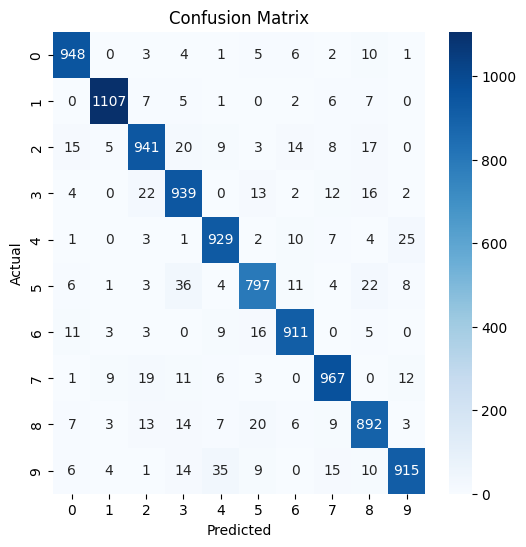

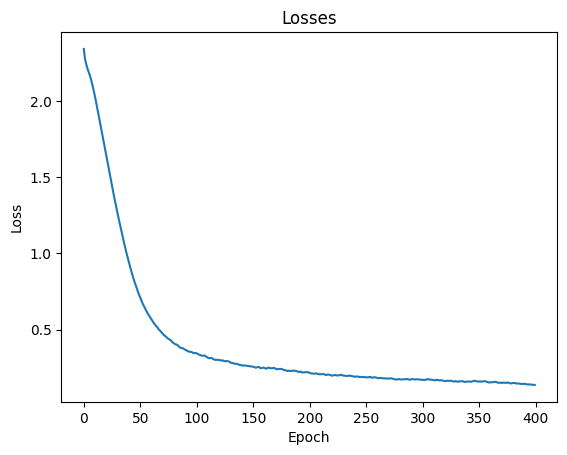

In [52]:
print_metrics(model)
plot_losses(losses)

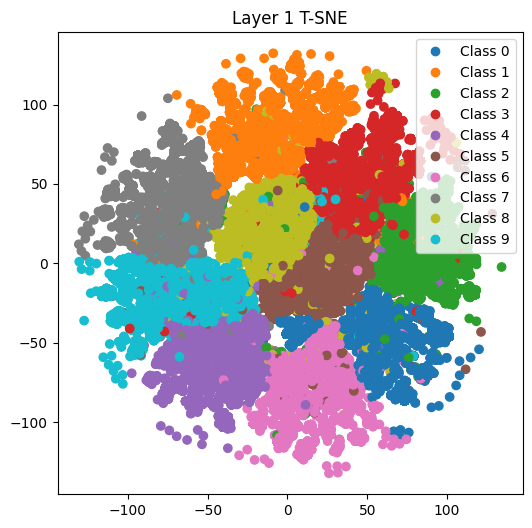

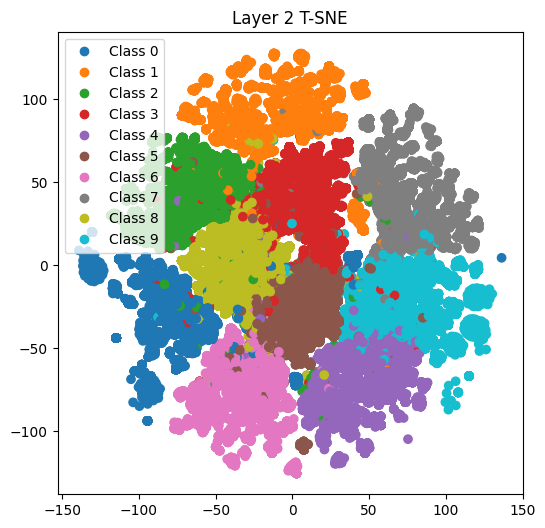

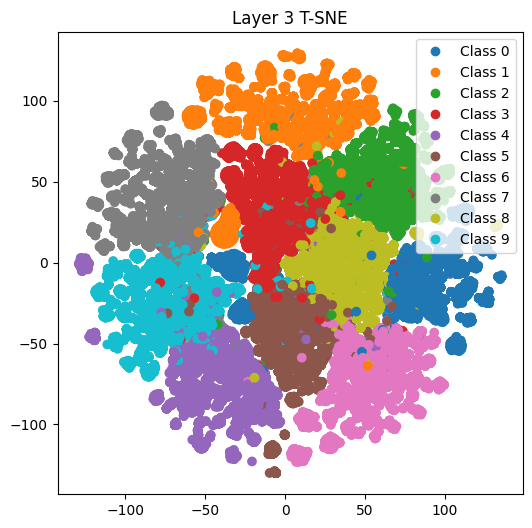

In [61]:
# plot t-sne of the features of each layer seperatly
from sklearn.manifold import TSNE

feats = model.get_feats(train_X)

for i in range(len(feats)):
	tsne = TSNE(n_components=2, random_state=42)
	embeddings_2d = tsne.fit_transform(feats[i])
	plt.figure(figsize=(6, 6))
	scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y, cmap="tab10")
	# print the legend of the classes
	legend_labels = [f"Class {label}" for label in range(10)]
	plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
	plt.title(f"Layer {i + 1} T-SNE")
	plt.show()